# Energy Price Data Exploratory Analysis

This notebook performs exploratory data analysis (EDA) on the processed energy price data for the Italian energy market from 2015-2024. It includes:
- Time series decomposition
- Stationarity tests
- Autocorrelation analysis
- Feature engineering
- Visualization generation
- Train/test split preparation

The goal is to understand patterns in energy prices and prepare the data for forecasting.


## Setup

Import required libraries and configure the environment.


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths - Fix path to be relative to script location
BASE_DIR = Path(os.getcwd()).parent
DATA_DIR = BASE_DIR / 'data/final/Italy'
IMAGES_DIR = BASE_DIR / 'outputs/images'

# Create output directory
IMAGES_DIR.mkdir(exist_ok=True, parents=True)


In [9]:
def load_data():
    """Load the processed price data"""
    print("Loading processed price data...")
    
    file_path = DATA_DIR / 'energy_price2015_2024.csv'
    print(f"Attempting to load data from: {file_path}")
    
    try:
        df = pd.read_csv(file_path)
        
        # Convert date column to datetime
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Set date as index for time series analysis
        df_ts = df.copy()
        df_ts.set_index('Date', inplace=True)
        
        print(f"Successfully loaded data with {df.shape[0]} rows and {df.shape[1]} columns.")
        return df, df_ts
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        print("Creating directory structure...")
        DATA_DIR.mkdir(exist_ok=True, parents=True)
        print(f"Please ensure the file exists at the specified location before running this script.")
        raise

def engineer_features(df):
    """Create time-based features for analysis"""
    print("Engineering time-based features...")
    
    # Create copy to avoid modifying original
    df_features = df.copy()
    
    # Extract time-based features
    df_features['day_of_week'] = df_features['Date'].dt.dayofweek
    df_features['day_name'] = df_features['Date'].dt.day_name()
    df_features['month'] = df_features['Date'].dt.month
    df_features['month_name'] = df_features['Date'].dt.month_name()
    df_features['quarter'] = df_features['Date'].dt.quarter
    df_features['year'] = df_features['Date'].dt.year
    df_features['day_of_year'] = df_features['Date'].dt.dayofyear
    df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)
    
    # Create lag features (previous day, week, month)
    df_features.set_index('Date', inplace=True)
    df_features['price_lag1'] = df_features['price_eur_mwh'].shift(1)
    df_features['price_lag7'] = df_features['price_eur_mwh'].shift(7)
    df_features['price_lag30'] = df_features['price_eur_mwh'].shift(30)
    
    # Create rolling window features
    df_features['price_rolling_7d_mean'] = df_features['price_eur_mwh'].rolling(window=7).mean()
    df_features['price_rolling_30d_mean'] = df_features['price_eur_mwh'].rolling(window=30).mean()
    
    # Reset index for easier use in other functions
    df_features.reset_index(inplace=True)
    
    return df_features

def test_stationarity(ts):
    """Perform stationarity tests on the time series"""
    print("Testing for stationarity...")
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(ts.dropna())
    adf_output = pd.Series(
        adf_result[0:4],
        index=['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    )
    for key, value in adf_result[4].items():
        adf_output[f'Critical Value ({key})'] = value
    
    # KPSS test
    kpss_result = kpss(ts.dropna())
    kpss_output = pd.Series(
        kpss_result[0:3],
        index=['KPSS Test Statistic', 'p-value', '# Lags Used']
    )
    for key, value in kpss_result[3].items():
        kpss_output[f'Critical Value ({key})'] = value
    
    print("\nAugmented Dickey-Fuller Test Results:")
    print(adf_output)
    print(f"Interpretation: {'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'}")
    
    print("\nKPSS Test Results:")
    print(kpss_output)
    print(f"Interpretation: {'Non-stationary' if kpss_result[1] < 0.05 else 'Stationary'}")
    
    return adf_output, kpss_output

def decompose_time_series(ts):
    """Decompose time series into trend, seasonal, and residual components"""
    print("Decomposing time series...")
    
    # Perform decomposition
    decomposition = seasonal_decompose(ts, model='additive', period=365)
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    # Original
    axes[0].plot(ts.index, ts, label='Original')
    axes[0].set_title('Original Time Series')
    axes[0].legend()
    
    # Trend
    axes[1].plot(decomposition.trend.index, decomposition.trend, color='blue')
    axes[1].set_title('Trend Component')
    
    # Seasonal
    axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, color='green')
    axes[2].set_title('Seasonal Component')
    
    # Residual
    axes[3].plot(decomposition.resid.index, decomposition.resid, color='red')
    axes[3].set_title('Residual Component')
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'price_decomposition.png', dpi=300)
    
    
    return decomposition

def autocorrelation_analysis(ts):
    """Perform autocorrelation and partial autocorrelation analysis"""
    print("Performing autocorrelation analysis...")
    
    # Calculate ACF and PACF
    lag_acf = acf(ts.dropna(), nlags=40)
    lag_pacf = pacf(ts.dropna(), nlags=40)
    
    # Create figure for ACF and PACF plots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # ACF plot
    plot_acf(ts.dropna(), lags=40, ax=axes[0])
    axes[0].set_title('Autocorrelation Function')
    
    # PACF plot
    plot_pacf(ts.dropna(), lags=40, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'price_acf_pacf.png', dpi=300)
    
    
    return lag_acf, lag_pacf

def generate_visualizations(df, df_features):
    """Generate visualizations for exploratory analysis"""
    print("Generating visualizations...")
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['price_eur_mwh'], color='blue')
    plt.title('Energy Price Time Series (2015-2024)')
    plt.xlabel('Date')
    plt.ylabel('Price (€/MWh)')
    plt.grid(True, alpha=0.3)
    plt.savefig(IMAGES_DIR / 'price_time_series.png', dpi=300)
    
    # Distribution plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price_eur_mwh'], kde=True, bins=30)
    plt.axvline(df['price_eur_mwh'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["price_eur_mwh"].mean():.2f}')
    plt.axvline(df['price_eur_mwh'].median(), color='green', linestyle='--', 
                label=f'Median: {df["price_eur_mwh"].median():.2f}')
    plt.title('Energy Price Distribution')
    plt.xlabel('Price (€/MWh)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(IMAGES_DIR / 'price_distribution.png', dpi=300)
    
    # Seasonal patterns - Monthly boxplot
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='month', y='price_eur_mwh', data=df_features)
    plt.title('Monthly Price Distribution')
    plt.xlabel('Month')
    plt.ylabel('Price (€/MWh)')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.savefig(IMAGES_DIR / 'price_monthly_boxplot.png', dpi=300)
    
    # Seasonal patterns - Day of week boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='day_of_week', y='price_eur_mwh', data=df_features)
    plt.title('Price Distribution by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Price (€/MWh)')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.savefig(IMAGES_DIR / 'price_day_of_week_boxplot.png', dpi=300)
    
    # Yearly trend
    yearly_avg = df_features.groupby('year')['price_eur_mwh'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='year', y='price_eur_mwh', data=yearly_avg, marker='o', linewidth=2)
    plt.title('Yearly Average Price Trend')
    plt.xlabel('Year')
    plt.ylabel('Average Price (€/MWh)')
    plt.grid(True, alpha=0.3)
    plt.savefig(IMAGES_DIR / 'price_yearly_trend.png', dpi=300)
    
    # Correlation heatmap for features
    corr_features = df_features[['price_eur_mwh', 'day_of_week', 'month', 'quarter', 'year',
                                'is_weekend', 'price_lag1', 'price_lag7', 'price_lag30',
                                'price_rolling_7d_mean', 'price_rolling_30d_mean']].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_features, dtype=bool))
    sns.heatmap(corr_features, annot=True, fmt=".2f", cmap='coolwarm', 
                mask=mask, vmin=-1, vmax=1)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'price_correlation_heatmap.png', dpi=300)
    
    # Plot lag features vs price
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Lag 1
    axes[0].scatter(df_features['price_lag1'], df_features['price_eur_mwh'], alpha=0.5)
    axes[0].set_title('Price vs Previous Day Price')
    axes[0].set_xlabel('Previous Day Price (€/MWh)')
    axes[0].set_ylabel('Price (€/MWh)')
    
    # Lag 7
    axes[1].scatter(df_features['price_lag7'], df_features['price_eur_mwh'], alpha=0.5)
    axes[1].set_title('Price vs Price 7 Days Ago')
    axes[1].set_xlabel('Price 7 Days Ago (€/MWh)')
    axes[1].set_ylabel('Price (€/MWh)')
    
    # Lag 30
    axes[2].scatter(df_features['price_lag30'], df_features['price_eur_mwh'], alpha=0.5)
    axes[2].set_title('Price vs Price 30 Days Ago')
    axes[2].set_xlabel('Price 30 Days Ago (€/MWh)')
    axes[2].set_ylabel('Price (€/MWh)')
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'price_lag_relationships.png', dpi=300)

def prepare_train_test_split(df_features):
    """Prepare train/test split for modeling"""
    print("Preparing train/test split...")
    
    # Sort by date to ensure chronological order
    df_features = df_features.sort_values('Date')
    
    # Remove rows with NaN values (from lag features)
    df_features = df_features.dropna()
    
    # Use 80% for training, 20% for testing (chronological split)
    train_size = int(len(df_features) * 0.75)
    
    train_data = df_features.iloc[:train_size]
    test_data = df_features.iloc[train_size:]
    
    print(f"Training data: {train_data.shape[0]} rows ({train_data['Date'].min()} to {train_data['Date'].max()})")
    print(f"Testing data: {test_data.shape[0]} rows ({test_data['Date'].min()} to {test_data['Date'].max()})")
    
    # Save the train/test split
    train_data.to_csv(DATA_DIR / 'price_train_data.csv', index=False)
    test_data.to_csv(DATA_DIR / 'price_test_data.csv', index=False)
    
    # Visualize the split
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['Date'], train_data['price_eur_mwh'], label='Training Data', color='blue')
    plt.plot(test_data['Date'], test_data['price_eur_mwh'], label='Testing Data', color='red')
    plt.axvline(x=train_data['Date'].max(), color='black', linestyle='--')
    plt.title('Train/Test Split for Price Data')
    plt.xlabel('Date')
    plt.ylabel('Price (€/MWh)')
    plt.legend()
    plt.savefig(IMAGES_DIR / 'price_train_test_split.png', dpi=300)
    
    return train_data, test_data


   

## Execute the Analysis

Run the main function to perform the complete EDA pipeline.


Starting exploratory data analysis for energy price data...
Loading processed price data...
Attempting to load data from: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy/energy_price2015_2024.csv
Successfully loaded data with 3653 rows and 8 columns.

Data preview:
        Date  price_eur_mwh  is_outlier  year  month  day  day_of_week  \
0 2015-01-01      45.472115       False  2015      1    1            3   
1 2015-01-02      56.988056       False  2015      1    2            4   
2 2015-01-03      50.532976       False  2015      1    3            5   
3 2015-01-04      45.106388       False  2015      1    4            6   
4 2015-01-05      53.368481       False  2015      1    5            0   

   is_weekend  
0       False  
1       False  
2        True  
3        True  
4       False  
Engineering time-based features...

Engineered features preview:
        Date  price_eur_mwh  is_outlier  year  month  day  day_of_week  \
0 2015-01-01      45.472115  

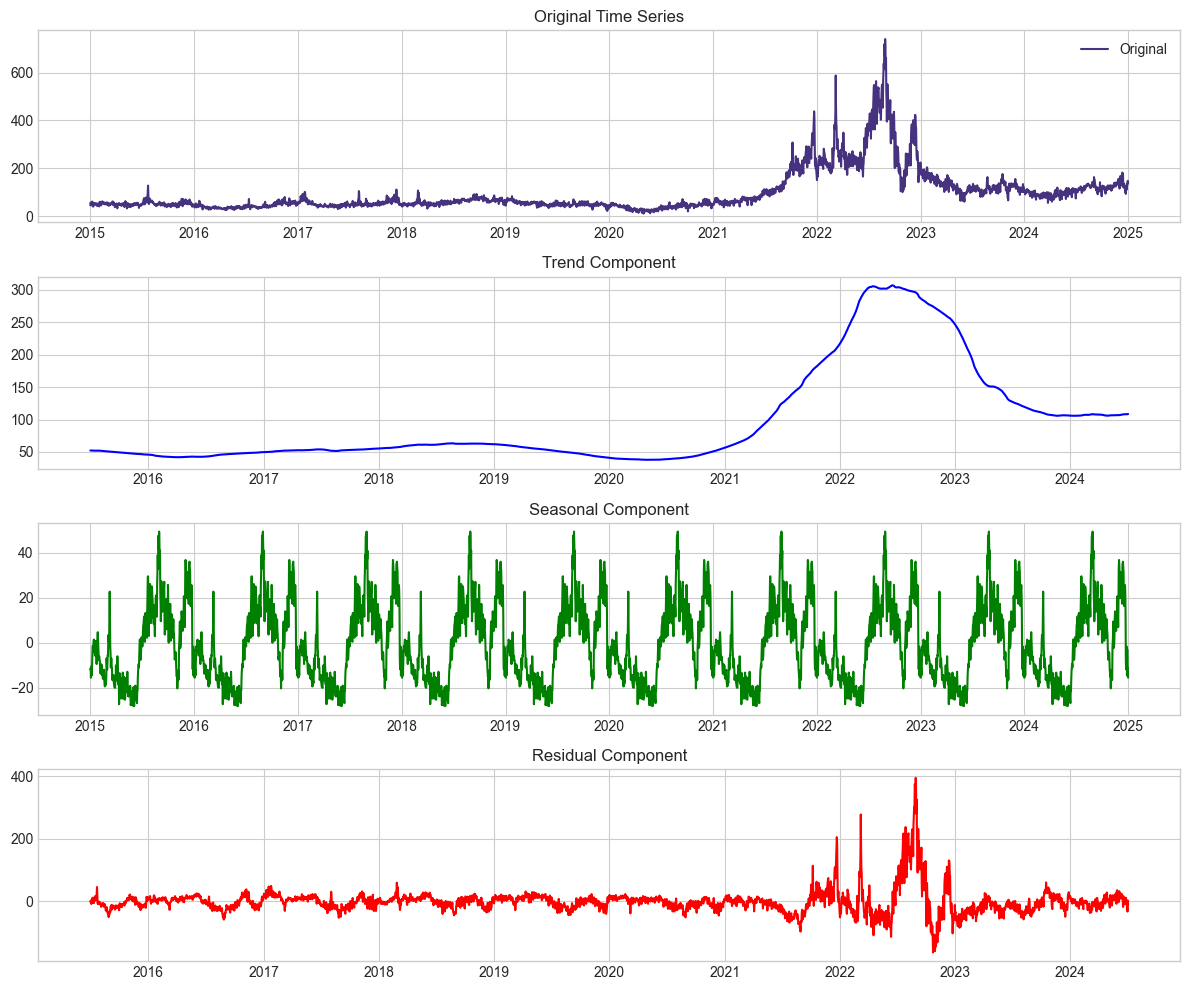

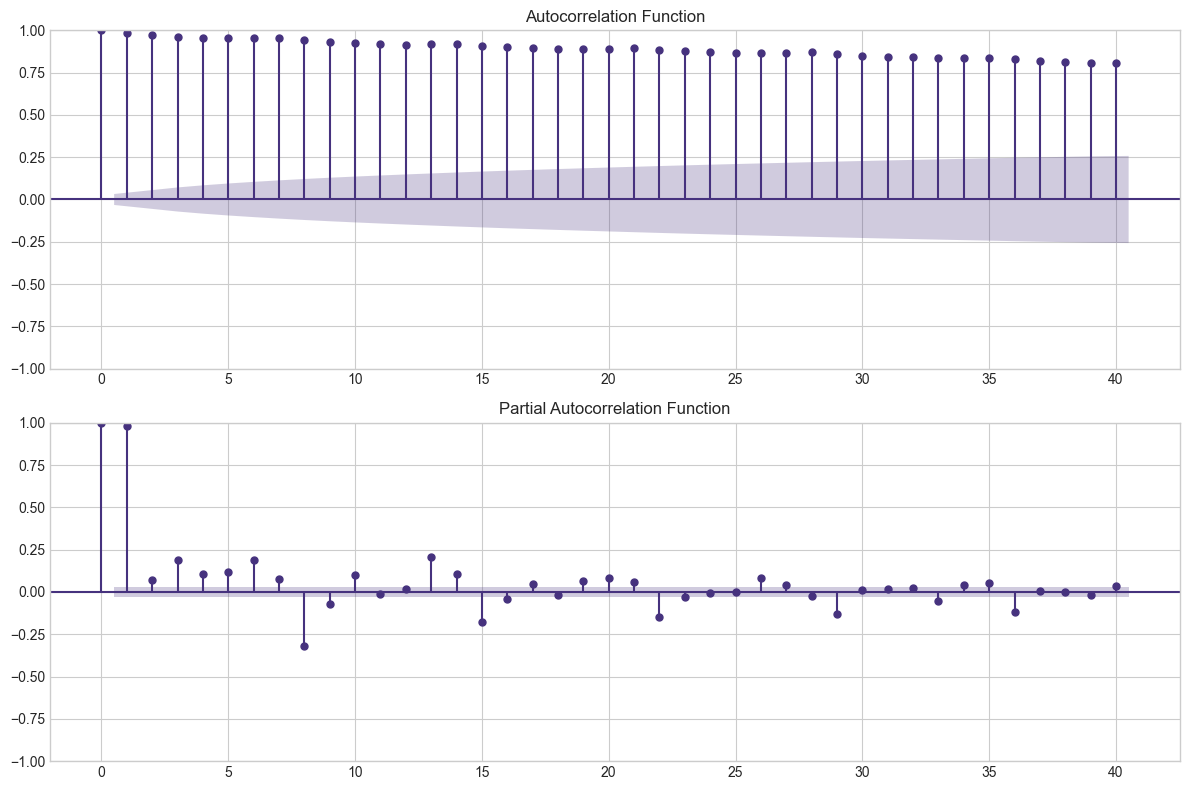

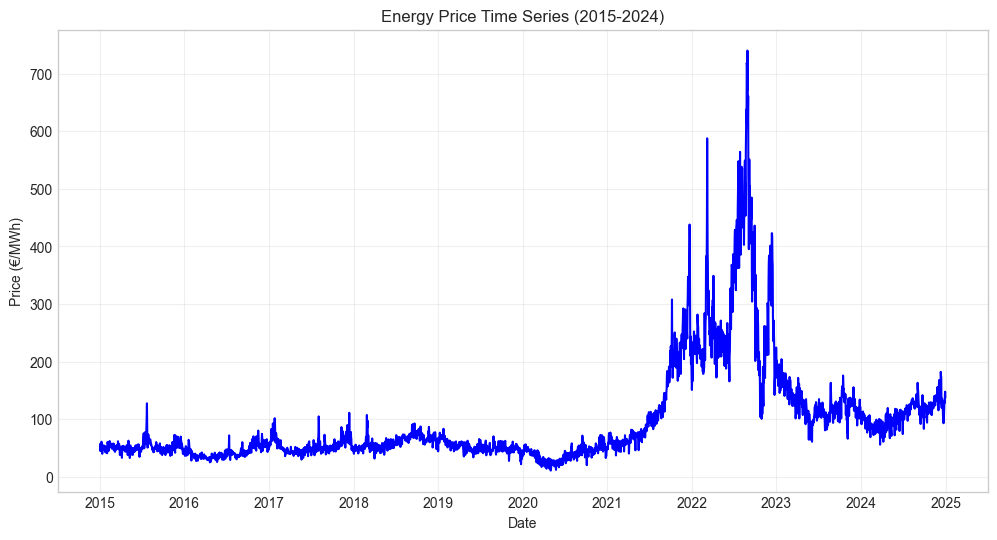

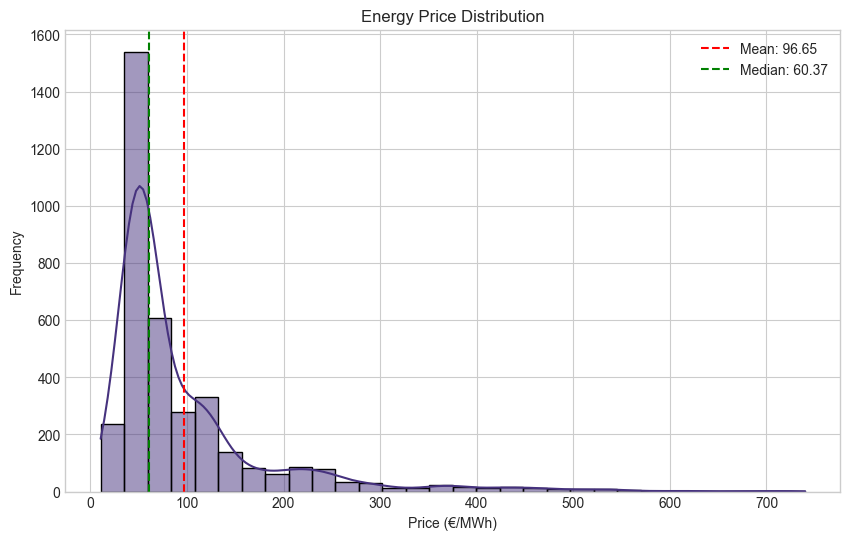

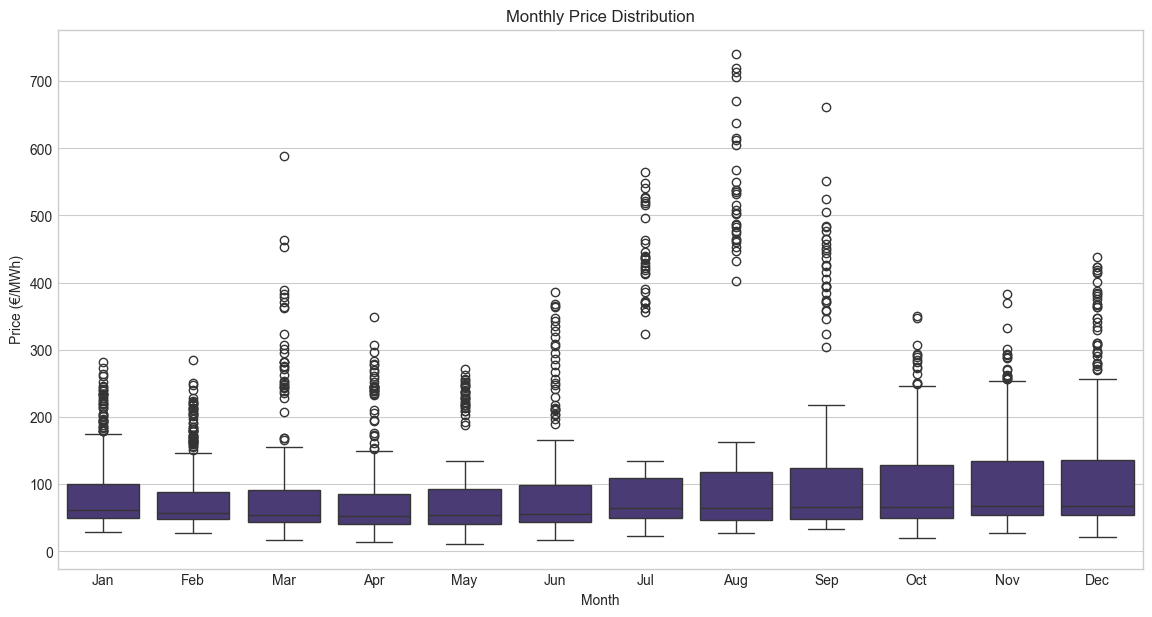

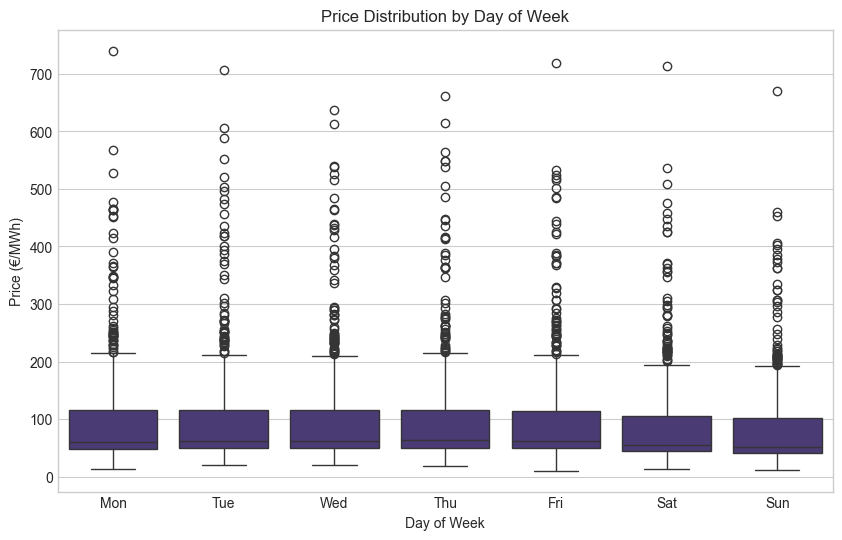

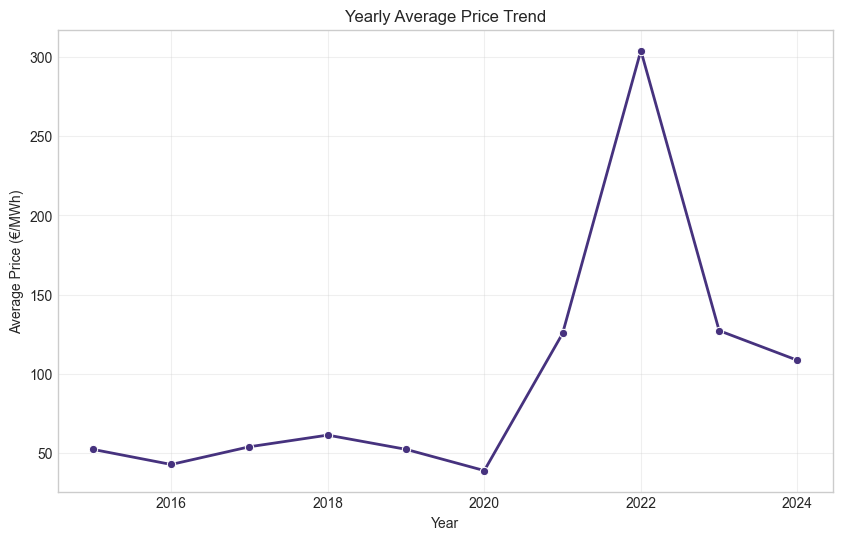

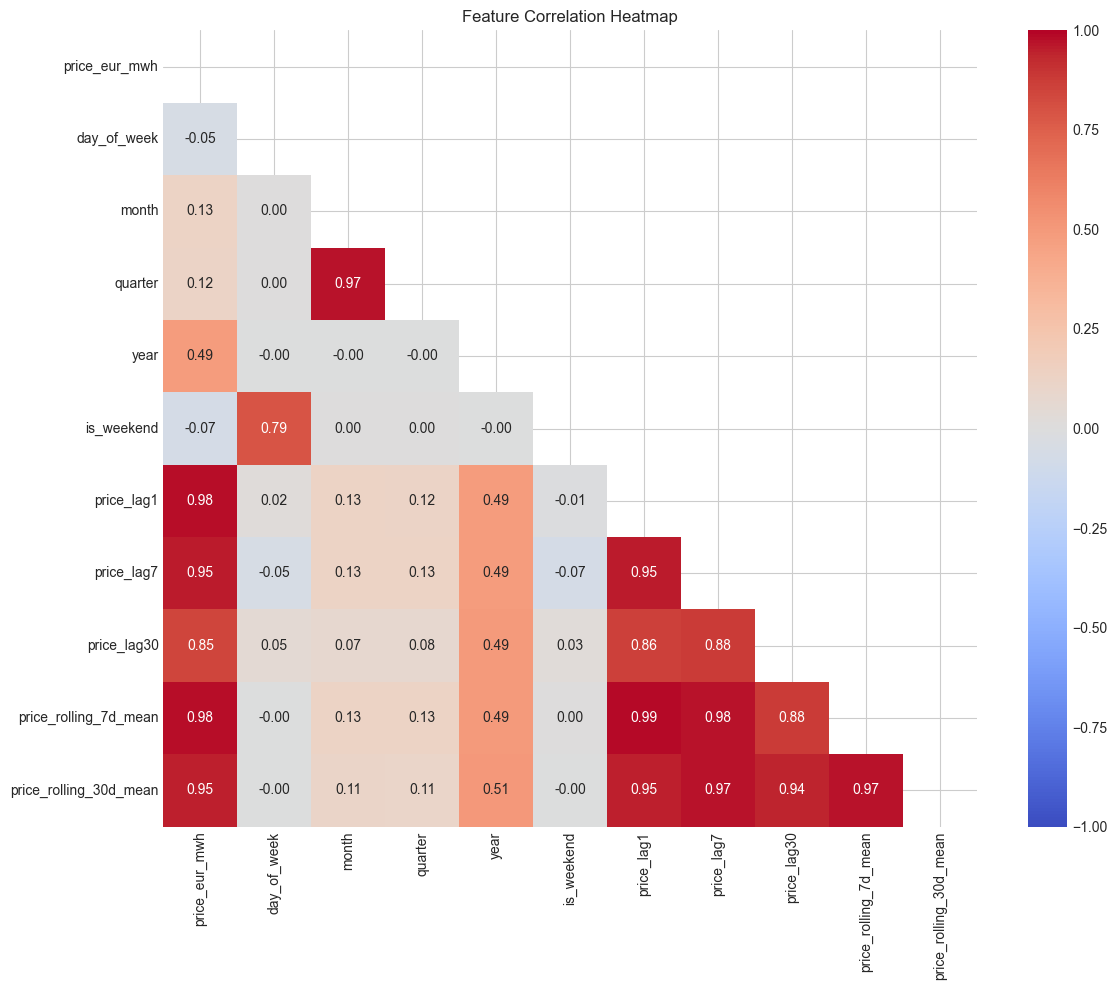

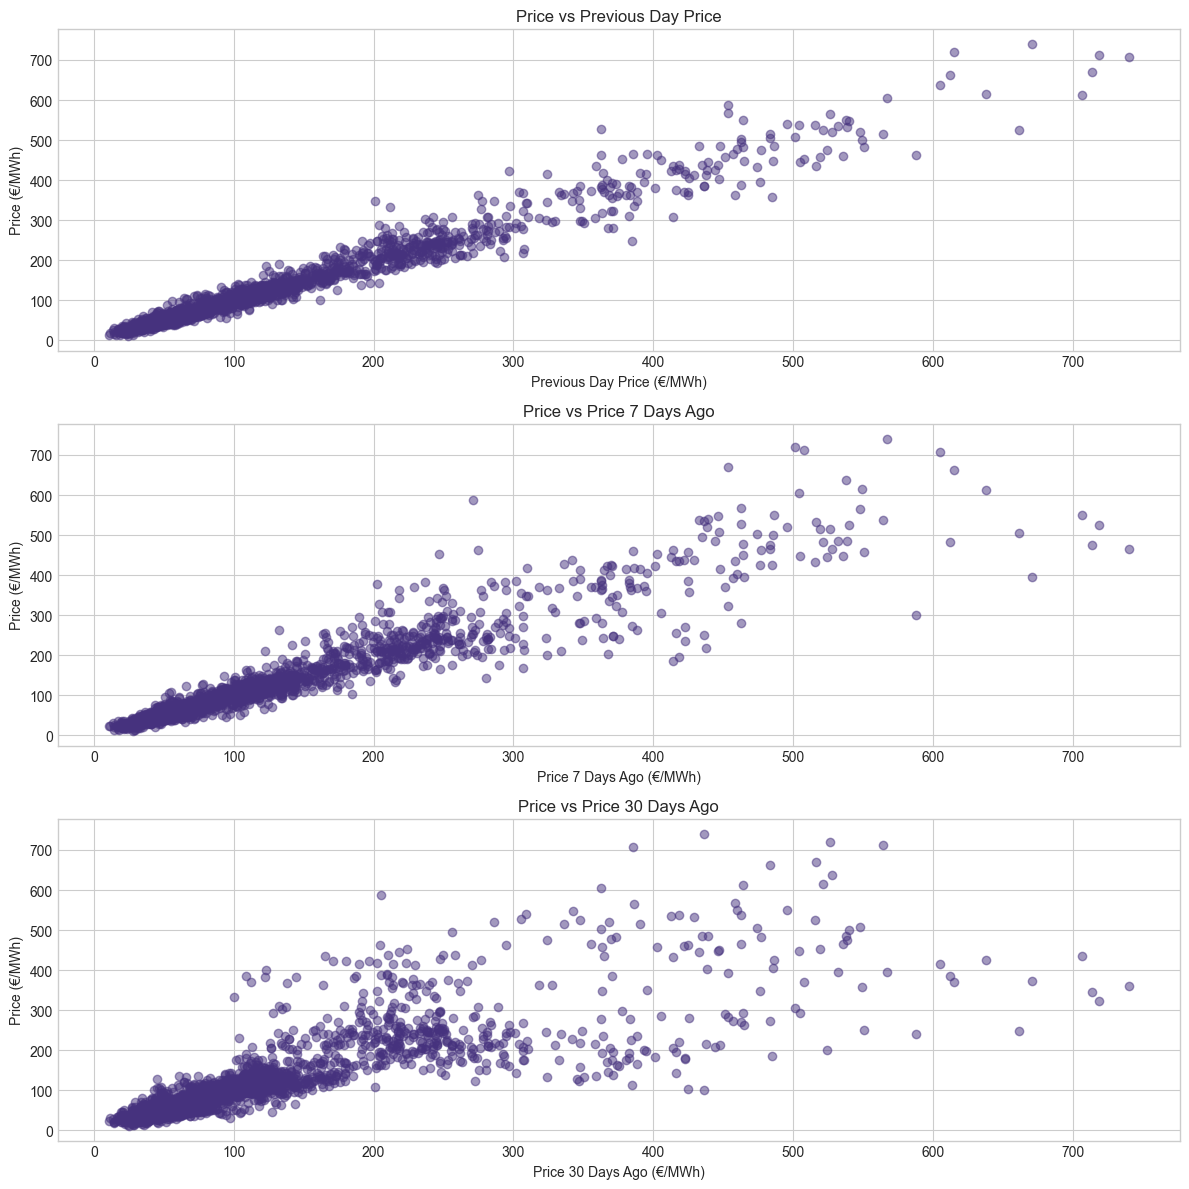

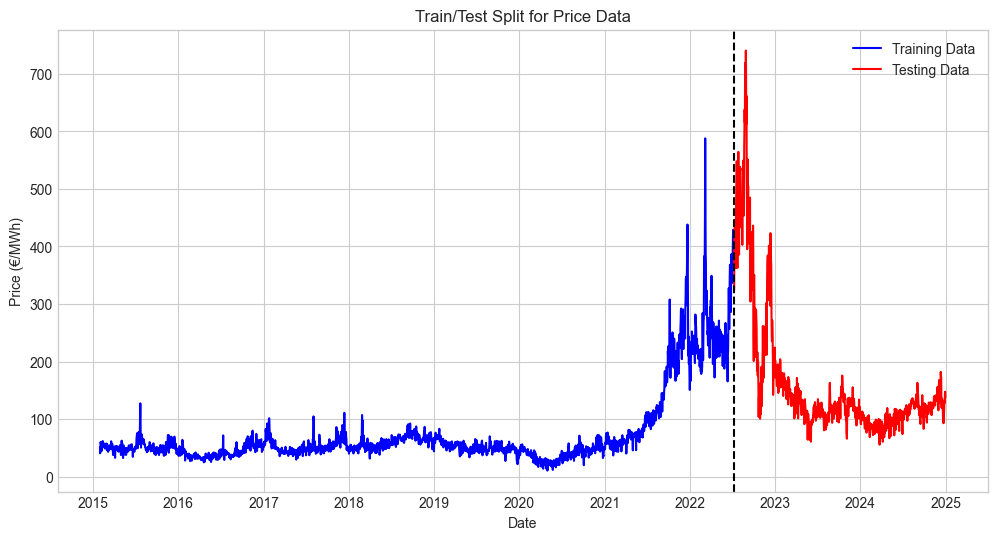

In [10]:
print("Starting exploratory data analysis for energy price data...")

# Load data
df, df_ts = load_data()
print("\nData preview:")
print(df.head())

# Engineer features
df_features = engineer_features(df)
print("\nEngineered features preview:")
print(df_features.head())

# Time series decomposition
decomposition = decompose_time_series(df_ts['price_eur_mwh'])

# Stationarity tests
adf_output, kpss_output = test_stationarity(df_ts['price_eur_mwh'])

# Autocorrelation analysis
lag_acf, lag_pacf = autocorrelation_analysis(df_ts['price_eur_mwh'])

# Generate visualizations
generate_visualizations(df, df_features)

# Prepare train/test split
train_data, test_data = prepare_train_test_split(df_features)

print("\nEDA complete! All visualizations saved to:", IMAGES_DIR)
print("Train/test data saved to:", DATA_DIR)

## Conclusion

This notebook has performed a comprehensive exploratory data analysis of the Italian energy price data from 2015-2024. Key findings include:

1. The time series shows clear seasonal patterns and trends
2. Stationarity tests reveal mixed results, suggesting potential need for differencing
3. Strong autocorrelation exists, especially at lag 1 and lag 7
4. Monthly and day-of-week patterns are evident in the data
5. The data has been successfully prepared for modeling with appropriate train/test splits

The generated visualizations and prepared datasets will be used for subsequent modeling tasks, particularly for training the price forecasting model.
